# 0. Check required versions of icechunk and xarray are installed

In [1]:
#!pip install git+https://github.com/zarr-developers/VirtualiZarr.git@ab/upgrade-icechunk#egg=VirtualiZarr[icechunk]
!pip list | grep -E '^(virtualizarr|icechunk|zarr|xarray)\s'

icechunk                  0.1.0a12
virtualizarr              1.2.1.dev20+g079e480
xarray                    2025.1.1
zarr                      3.0.1


In [6]:
import icechunk
assert(icechunk.__version__ == "0.1.0-alpha.12")

In [7]:
import fsspec
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import zarr

import helpers

# 1. Set zarr runtime configuration

Async and threading operations can be set via zarr.config. 

* `async.concurrency` controls how many chunks can be fetched asynchronously at once.
* `threading.max_workers` determines how many threads handle the decompression or processing of those fetched chunks.

From some adhoc testing, it looks like CPU is saturated at `async.concurrency = ~30` and `threading.max_workers` makes no impact. The default setting for `threading.max_workers` is `None` so presumably this uses all threads available?

In [8]:
zarr.config.set({
    'async': {'concurrency': 100, 'timeout': None},
    'threading': {'max_workers': None}
})

# 2. Initialize the repo

In [9]:
repo = helpers.find_or_create_icechunk_repo(
    store_name="MUR-JPL-L4-GLOB-v4.1-virtual-v4/",
    store_type="s3",
    overwrite=False
)
session = repo.readonly_session(branch="main")

# 3. Read and plot the data with xarray

In [10]:
%%time
xds = xr.open_zarr(session.store, consolidated=False, zarr_format=3)

/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)
/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcode

CPU times: user 10.6 s, sys: 2.58 s, total: 13.2 s
Wall time: 24.2 s


In [11]:
xds

<xarray.Dataset> Size: 141TB
Dimensions:           (time: 7765, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * time              (time) datetime64[ns] 62kB 2002-06-01T09:00:00 ... 2023...
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float64 40TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 40TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 40TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 20TB dask.array<chunksize=(1, 1447, 2895), meta=np.ndarray>
Attributes: (12/47)
    Conventions:                CF-1.7
    Metadata_Conventions:       Unidata Observation Dataset v1.0
    acknowledgment:             Please acknowledge the use of these data with...
    cdm_data_type:              grid
    comment:                    MUR = "Multi-scale Ultra-high Resolution"
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    ...                         ...
    summary:                    A merged, multi-sensor L4 Foundation SST anal...
    time_coverage_end:          20230423T210000Z
    time_coverage_start:        20230422T210000Z
    title:                      Daily MUR SST, Final product
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:      -180.0

In [12]:
%%time
data = xds.analysed_sst.sel(lat=slice(48, 49), lon=slice(-125, -124)).mean(["lat", "lon"]).load()

CPU times: user 2min 47s, sys: 22.2 s, total: 3min 9s
Wall time: 2min 4s


CPU times: user 15.1 ms, sys: 353 μs, total: 15.5 ms
Wall time: 16.4 ms


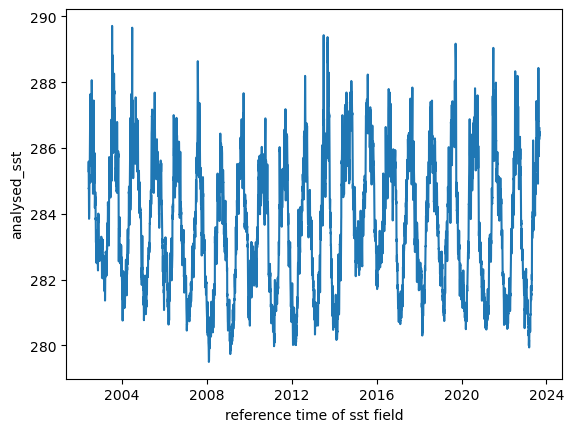

In [13]:
%%time
data.plot()

# 4. Read and plot the data with zarr-python

In [14]:
%%time
# Open Zarr store
zarr_store = zarr.open(session.store, mode="r")

CPU times: user 2.34 ms, sys: 1.77 ms, total: 4.11 ms
Wall time: 2.58 ms


In [15]:
lat_range = [48,49]
lat_min = -90
lon_range = [-125,-124]
lon_min = -180
resolution = 0.01
lat_indices = [int((lat - lat_min)/resolution) for lat in lat_range]
lon_indices = [int((lon - lon_min)/resolution) for lon in lon_range]
lat_indices, lon_indices

([13800, 13900], [5500, 5600])

In [16]:
%%time
sst_subset = zarr_store["analysed_sst"][:, lat_indices[0]:lat_indices[1], lon_indices[0]:lon_indices[1]]
sst_mean = np.mean(sst_subset, axis=(1, 2))

/opt/conda/lib/python3.11/site-packages/numcodecs/zarr3.py:132: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


CPU times: user 2min 46s, sys: 26.1 s, total: 3min 12s
Wall time: 37.9 s


In [17]:
print(f"Fetched {'{:,}'.format(np.prod(sst_subset.shape))} points")

Fetched 77,650,000 points


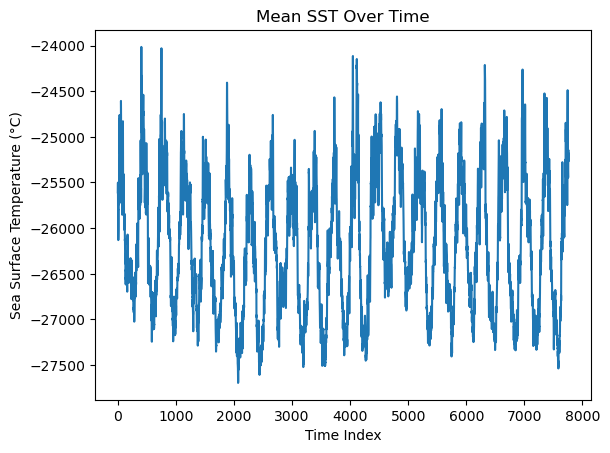

CPU times: user 139 ms, sys: 3.2 ms, total: 142 ms
Wall time: 142 ms


In [18]:
%%time
plt.plot(sst_mean)
plt.title("Mean SST Over Time")
plt.xlabel("Time Index")
plt.ylabel("Sea Surface Temperature (°C)")  # Replace with correct units
plt.show()